# SPARC-4 Astrometry
***

This notebook shows a few examples on how to use the sparc4-pipeline tools to obtain an astrometric solution of a field and how to check the astrometric solution in the SPARC4 data products.

* Eder Martioli, LNA 13 Mar 2024

In [1]:
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats
from astropy.wcs.utils import fit_wcs_from_points

import photutils

import twirl
from aafitrans import find_transform

from sparc4.pipeline_lib import set_wcs_from_astrom_ref_image, astrometry_from_existing_wcs
from sparc4.utils import check_astrometry

# 1. Check astrometric solution in a "stack" or "proc" FITS product

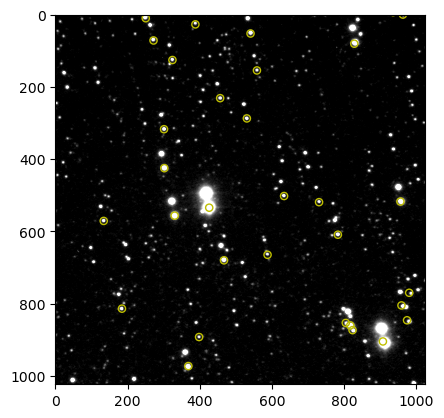

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 192.76126420052  -61.253479032653  
CRPIX : 443.88321197616  432.87922619665  
PC1_1 PC1_2  : -9.4594169069913e-05  9.7045534947731e-07  
PC2_1 PC2_2  : 1.0198632467722e-06  9.4515654169999e-05  
CDELT : 1.0  1.0  
NAXIS : 1024  1024

In [4]:
# First a photometric frame
#reduced_data_dir = '/Users/eder/Data/SPARC4/minidata/reduced/20230605/sparc4acs3/'
#filename = reduced_data_dir + '20230605_s4c3_Gain1_1_Conventional_2_CR3__stack.fits'

# Then a polarimetric frame
reduced_data_dir = '/Users/eder/Data/SPARC4/minidata/reduced/20230606/sparc4acs4/'
filename = reduced_data_dir + '20230606_s4c4_Gain1_1_Conventional_2_hd111579_POLAR_L2__stack.fits'

check_astrometry(filename, nsources_to_plot=100) 

# 2. Load catalog data and re-calculate astrometry

In [5]:
#filename = "/Users/eder/Data/SPARC4/minidata/reduced/sparc4acs1/20230604/20230604_s4c1_Gain1_1_Conventional_2_Hilt652_POLAR_L2__stack.fits"
hdul = fits.open(filename)
img_data, hdr = hdul[0].data, hdul[0].header

if hdr['INSTMODE'] == "POLAR" :
    ra = hdul["CATALOG_POL_S_AP010"].data["RA"]
    dec = hdul["CATALOG_POL_S_AP010"].data["DEC"]
    x = hdul["CATALOG_POL_S_AP010"].data["X"]
    y = hdul["CATALOG_POL_S_AP010"].data["Y"]
elif hdr['INSTMODE'] == "PHOT" :
    ra = hdul["CATALOG_PHOT_AP010"].data["RA"]
    dec = hdul["CATALOG_PHOT_AP010"].data["DEC"]
    x = hdul["CATALOG_PHOT_AP010"].data["X"]
    y = hdul["CATALOG_PHOT_AP010"].data["Y"]
    
pixel_coords = np.ndarray((len(x), 2))
sky_coords = np.ndarray((len(ra), 2))
for j in range(len(x)) :
    pixel_coords[j] = [x[j],y[j]]
    sky_coords[j] = [ra[j],dec[j]]    

In [6]:
# Here one can decide whether or not to use reference image wcs (if current wcs is too bad or doesn't exist)
use_ref_image = False

# initialize empty wcs
w = WCS(naxis=2)

if use_ref_image :
    # load exising wcs from a reference image header
    ref_filename = "/Users/eder/sparc4-pipeline/calibdb/20230503_s4c2_CR1_astrometryRef_stack.fits"
    w = set_wcs_from_astrom_ref_image(ref_filename, hdr)  
else :
    # load existing wcs from image header
    w = WCS(hdr,naxis=2)

## 2.1 Solve astrometry using catalog data only

WCSAXES = 2
CRPIX1 = 522.50524267322
CRPIX2 = 512.98615300052
PC1_1 = -9.4593923394555e-05
PC1_2 = 9.9258438155062e-07
PC2_1 = 1.0420055102187e-06
PC2_2 = 9.4515420727052e-05
CDELT1 = 1.0
CDELT2 = 1.0
CUNIT1 = deg
CUNIT2 = deg
CTYPE1 = RA---TAN
CTYPE2 = DEC--TAN
CRVAL1 = 192.74596557656
CRVAL2 = -61.24582663098
LONPOLE = 180.0
LATPOLE = -61.24582663098
MJDREF = 0.0
RADESYS = ICRS


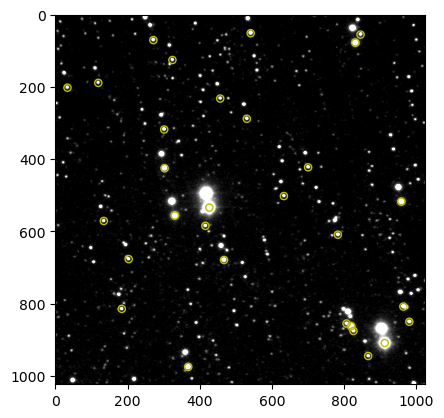

In [8]:
w = astrometry_from_existing_wcs(w, 
                                 img_data, 
                                 pixel_coords=pixel_coords, 
                                 sky_coords=sky_coords,
                                 max_number_of_catalog_sources=50,
                                 fov_search_factor=1.0, 
                                 plot_solution=True)

## 2.2 Solve astrometry using x,y catalog data only and detect+match Gaia sources

2024-09-20 10:51:28,383 root - INFO - No sky coordinates given, searching sources in online catalogs  [pipeline_lib]


2024-09-20 10:51:28,383 | INFO | No sky coordinates given, searching sources in online catalogs


2024-09-20 10:51:28,385 root - INFO - Querying Gaia DR3 using twirl  [pipeline_lib]


2024-09-20 10:51:28,385 | INFO | Querying Gaia DR3 using twirl


2024-09-20 10:51:29,829 root - INFO - Matching sources with catalog and solving astrometry to compute WCS  [pipeline_lib]


2024-09-20 10:51:29,829 | INFO | Matching sources with catalog and solving astrometry to compute WCS
WCSAXES = 2
CRPIX1 = 443.98080038982
CRPIX2 = 433.00205464347
PC1_1 = -9.4661431788306e-05
PC1_2 = 9.0544443303686e-07
PC2_1 = 1.0961023948287e-06
PC2_2 = 9.4602097144705e-05
CDELT1 = 1.0
CDELT2 = 1.0
CUNIT1 = deg
CUNIT2 = deg
CTYPE1 = RA---TAN
CTYPE2 = DEC--TAN
CRVAL1 = 192.76126420052
CRVAL2 = -61.253479032653
LONPOLE = 180.0
LATPOLE = -61.253479032653
MJDREF = 0.0
RADESYS = ICRS


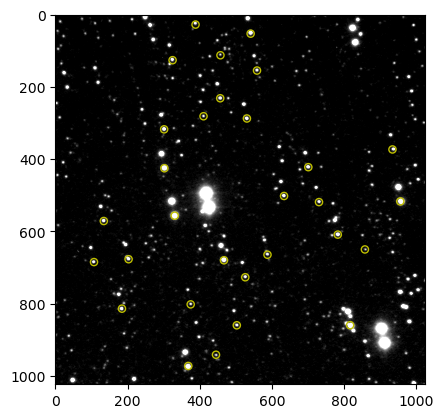

In [10]:
w = astrometry_from_existing_wcs(w, 
                                 img_data, 
                                 pixel_coords=pixel_coords, 
                                 max_number_of_catalog_sources=50,
                                 fov_search_factor=1.0, 
                                 plot_solution=True)

## 2.3 Check solution again

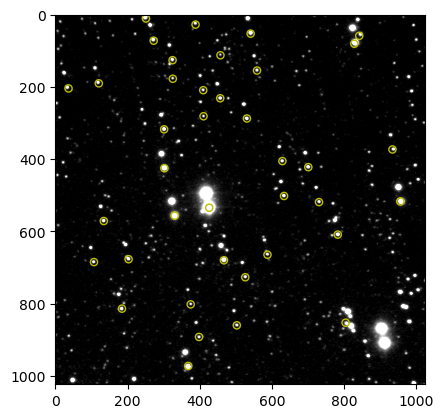

In [11]:
catalog_sky_coords = np.array(w.pixel_to_world_values(pixel_coords))

center = SkyCoord(w.wcs.crval[0], w.wcs.crval[1], unit=(u.deg,u.deg))
fov = (img_data.shape * proj_plane_pixel_scales(w))[0]
gaia_sources_skycoords = twirl.gaia_radecs(center, 1.1 * fov)[:50]
gaia_sources_pixcoords = np.array(w.world_to_pixel_values(gaia_sources_skycoords))

plt.imshow(img_data, vmin=np.median(img_data), vmax=3 * np.median(img_data), cmap="Greys_r")
_ = photutils.aperture.CircularAperture(gaia_sources_pixcoords, r=10.0).plot(color="y")